# Import

## packages

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config IPCompleter.use_jedi = False

import pandas as pd
import pickle
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import wilcoxon

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'png'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 120
sns.set_style('ticks')

In [ ]:
from signature_validation.utils.utils import read_dataset, to_common_samples
from signature_validation.utils.fges_utils import select_runs, get_ls_and_ss


from signature_validation.ssgsea_calc.ssgsea_calc import (
    read_gene_sets,
    detect_fges_source,
)
from signature_validation.plotting.plotting import patch_plot, boxplot_with_pvalue

## functions

<Axes: >

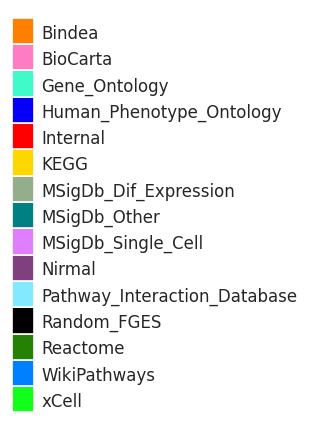

In [ ]:
signature_palette = {
    "Internal": "#ff0000",
    "Random_FGES": "black",
    "xCell": "#12ff1b",
    "Bindea": "#ff8000",
    "Nirmal": "#804080",
    "Gene_Ontology": "#40fbc9",
    "KEGG": "gold",
    "BioCarta": "#fe7cc3",
    "WikiPathways": "#0080ff",
    "Reactome": "#258103",
    "Pathway_Interaction_Database": "#83e9ff",
    "Human_Phenotype_Ontology": "#0500f5",
    "MSigDb_Dif_Expression": "#93ae8b",
    "MSigDb_Single_Cell": "#df7ffe",
    "MSigDb_Other": "#008080",
}
signture_order = [
    "Internal",
    "Nirmal",
    "Bindea",
    "xCell",
    "Gene_Ontology",
    "Human_Phenotype_Ontology",
    "WikiPathways",
    "MSigDb_Single_Cell",
    "MSigDb_Other",
    "MSigDb_Dif_Expression",
    "Random_FGES",
]
patch_plot(signature_palette)

## data

In [ ]:
all_msigdb_gmt = read_gene_sets("./data/msigdb.v2023.1.Hs.symbols.gmt")

In [ ]:
p = Path("./data/")
with open(p / "mapping_ssgseas.pkl", "rb") as handle:
    mapping_ssgseas = pickle.load(handle)
for key in mapping_ssgseas.keys():
    for i in mapping_ssgseas[key]["Goi"].keys():
        print(key, "\t", i, "\t", mapping_ssgseas[key]["Goi"][i].shape)

Main4_Th1_signature 	 Th1_cells 	 (20, 65)
Main4_CD8_T_cells 	 CD8_T_cells 	 (453, 269)
Main4_Treg 	 Tregs 	 (73, 168)
Main4_Neutrophil_signature 	 Neutrophils 	 (199, 107)
Main4_Mast_cell_signature 	 Mast_cells 	 (51, 53)
Main4_Effector_cells 	 CD8_T_cells 	 (453, 386)
Main4_Effector_cells 	 NK_cells 	 (202, 386)
Main4_Eosinophil_signature 	 Eosinophils 	 (12, 39)
Main4_Follicular_helper_T_cells 	 Follicular_T_helper_tonsil 	 (24, 50)
Main4_B_cells 	 B_cells 	 (504, 378)
Main4_Endothelium 	 Endothelium 	 (322, 98)
Main4_Pan_macrophage_signature 	 Macrophages 	 (527, 261)
Main4_NK_cells 	 NK_cells 	 (202, 108)
Main4_M2_signature 	 Macrophages_M2 	 (23, 20)
Main4_T_cells 	 T_cells 	 (164, 155)
Main4_CD4_T_cells 	 CD4_T_cells 	 (1699, 423)
Main4_CD4_T_cells 	 CD4_T_helpers 	 (73, 423)
Main4_Lymphatic_endothelium 	 Endothelium_lymph 	 (89, 26)
Main4_Th17_signature 	 Th17_cells 	 (19, 54)
Main4_Plasma_cells 	 Plasma_B_cells 	 (11, 45)
Main4_Plasma_cells 	 Plasmablasts 	 (14, 45)
Main4_Mono

In [ ]:
with open(p / "msigdb_gmt.pkl", "rb") as handle:
    msigdb_gmt = pickle.load(handle)

# Preparation

In [ ]:
control_labels = []
control_ss = []
goi_ss = []
goi_labels = []
for bg_fges in mapping_ssgseas.keys():
    goi = pd.concat(mapping_ssgseas[bg_fges]["Goi"])
    control = pd.concat(mapping_ssgseas[bg_fges]["Control"])
    for fges in goi.columns:
        fges_type = detect_fges_source(fges)

        ls, ss = get_ls_and_ss(control[fges], fges_type, fges)
        control_ss.append(ss)
        control_labels.append(ls)

        ls, ss = get_ls_and_ss(goi[fges], fges_type, fges)
        goi_ss.append(ss)
        goi_labels.append(ls)


control_labels = pd.concat(control_labels)
control_ss = pd.concat(control_ss)
goi_ss = pd.concat(goi_ss)
goi_labels = pd.concat(goi_labels)

In [15]:
goi_labels.value_counts()

MSigDb_Dif_Expression           1417328
Random_FGES                       55690
MSigDb_Single_Cell                54991
xCell                             51301
Gene_Ontology                     28147
MSigDb_Other                       9998
Human_Phenotype_Ontology           6731
Internal                           5569
WikiPathways                       5556
Bindea                             3894
Nirmal                             2711
KEGG                               1525
BioCarta                           1301
Reactome                            776
Pathway_Interaction_Database        199
dtype: int64

In [16]:
control_labels.value_counts()

MSigDb_Dif_Expression           14834948
Random_FGES                      1308430
MSigDb_Single_Cell               1069697
xCell                             802825
Gene_Ontology                     549096
MSigDb_Other                      204889
Human_Phenotype_Ontology          163877
Internal                          130843
WikiPathways                      116664
Bindea                             87188
Nirmal                             55740
BioCarta                           28956
KEGG                               27656
Reactome                           21103
Pathway_Interaction_Database        7704
dtype: int64

In [17]:
goi_ss = goi_ss[~goi_ss.index.duplicated()]
goi_labels = goi_labels[~goi_labels.index.duplicated()]
control_ss = control_ss[~control_ss.index.duplicated()]
control_labels = control_labels[~control_labels.index.duplicated()]

In [18]:
goi_labels_good = goi_labels[goi_labels.isin(signture_order)]
control_labels_good = control_labels[control_labels.isin(signture_order)]

In [ ]:
goi_cell_types = pd.Series(
    index=goi_labels_good.index,
    data=goi_labels_good.index.map(lambda x: x.split("', ")[0].replace("('", "")),
)
control_cell_types = pd.Series(
    index=control_labels_good.index,
    data=control_labels_good.index.map(lambda x: x.split("', ")[0].replace("('", "")),
)

<Axes: xlabel='col_0', ylabel='row_0'>

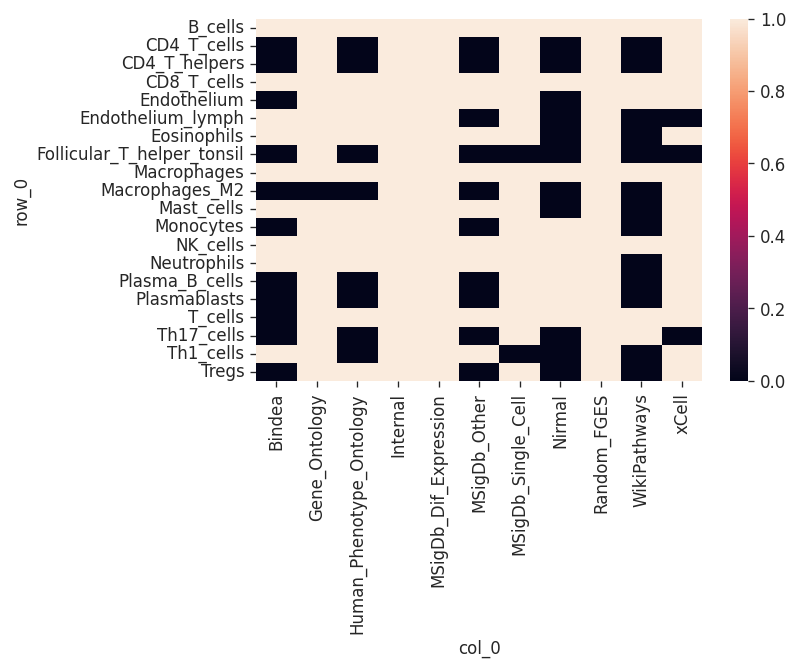

In [ ]:
sns.heatmap(pd.crosstab(goi_cell_types, goi_labels), vmin=0, vmax=1)

In [ ]:
ct_vs_ls = pd.crosstab(goi_cell_types, goi_labels)
good_goi_ct = [
    ct for ct in ct_vs_ls.index if len(ct_vs_ls.loc[ct][ct_vs_ls.loc[ct] == 0]) == 0
]
print(", ".join(good_goi_ct))

ct_vs_ls = pd.crosstab(control_cell_types, control_labels)
good_control_ct = [
    ct for ct in ct_vs_ls.index if len(ct_vs_ls.loc[ct][ct_vs_ls.loc[ct] == 0]) == 0
]
print(", ".join(good_control_ct))

B_cells, CD8_T_cells, Macrophages, NK_cells
Astrocytes, B_cells, CD4_T_cells, CD4_T_helpers, CD8_T_cells, CD8_T_cells_PD1_high, Cardiac_myofibroblasts, Dendritic_cells, Endothelium, Endothelium_lymph, Eosinophils, Epithelium, Fibroblasts, Follicular_T_helper, Follicular_T_helper_tonsil, Hepatocytes, Keratinocytes, MAIT_cells, Macrophages, Macrophages_M1, Macrophages_M2, Mast_cells, Memory_CD8_T_cells, Monocytes, Monocytic_DC, Myeloid_cells, NK_cells, Neurons, Neutrophils, Non_plasma_B_cells, Pancreatic_cells, Plasma_B_cells, Plasmablasts, T_cells, Th17_cells, Th1_cells, Th2_cells, Tregs


In [ ]:
goi_labels_good = goi_labels_good[goi_cell_types.isin(good_goi_ct)]
control_labels_good = control_labels_good[control_cell_types.isin(good_control_ct)]
goi_ss, goi_labels_good = to_common_samples((goi_ss, goi_labels_good))
control_ss, control_labels_good = to_common_samples((control_ss, control_labels_good))

In [23]:
goi_labels_good.value_counts()

MSigDb_Dif_Expression       479964
xCell                        24873
MSigDb_Single_Cell           23740
Random_FGES                  23410
Gene_Ontology                14511
MSigDb_Other                  6721
WikiPathways                  3221
Bindea                        2868
Human_Phenotype_Ontology      2845
Internal                      2341
Nirmal                        1686
dtype: int64

In [24]:
control_labels_good.value_counts()

MSigDb_Dif_Expression       12567652
Random_FGES                  1307470
MSigDb_Single_Cell            842371
xCell                         724414
Gene_Ontology                 520426
MSigDb_Other                  168637
Human_Phenotype_Ontology      149415
Internal                      130747
WikiPathways                  109427
Bindea                         72982
Nirmal                         48527
dtype: int64

In [ ]:
goi_runs = pd.Series(
    index=goi_labels_good.index,
    data=goi_labels_good.index.map(lambda x: x.split("', '")[1].split("')_")[0]),
)
control_runs = pd.Series(
    index=control_labels_good.index,
    data=control_labels_good.index.map(lambda x: x.split("', '")[1].split("')_")[0]),
)

In [ ]:
goi_min_runs = goi_runs.reindex(goi_labels_good[goi_labels_good == "Nirmal"].index)
print(goi_min_runs.value_counts())
goi_min_cts = goi_cell_types.reindex(goi_labels_good[goi_labels_good == "Nirmal"].index)
print(goi_min_cts.value_counts())

control_min_runs = control_runs.reindex(
    control_labels_good[control_labels_good == "Nirmal"].index
)
print(control_min_runs.value_counts())
control_min_cts = control_cell_types.reindex(
    control_labels_good[control_labels_good == "Nirmal"].index
)
control_min_cts.value_counts()

SRX3862207    1
SRX5294206    1
SRX8943736    1
SRX8150219    1
SRX1738979    1
             ..
SRX1739195    1
SRX4677054    1
SRX4677053    1
SRX3208718    1
SRX3797681    1
Length: 1686, dtype: int64
Macrophages    527
B_cells        504
CD8_T_cells    453
NK_cells       202
dtype: int64
SRX3118433    7
SRX3601437    7
SRX6689056    7
SRX7207802    7
SRX3601431    7
             ..
ERX211467     4
ERX211463     4
SRX8286797    4
SRX1433439    4
SRX9398712    4
Length: 7990, dtype: int64


CD4_T_cells                   10194
Fibroblasts                    7140
Monocytic_DC                   3270
CD8_T_cells                    2718
Macrophages                    2635
B_cells                        2520
Endothelium                    2254
Monocytes                      2175
Keratinocytes                  1967
NK_cells                       1212
Neutrophils                    1194
Cardiac_myofibroblasts         1176
Dendritic_cells                1022
T_cells                         984
Macrophages_M1                  945
Hepatocytes                     791
Non_plasma_B_cells              768
MAIT_cells                      637
Endothelium_lymph               623
Tregs                           438
CD4_T_helpers                   438
Memory_CD8_T_cells              378
Myeloid_cells                   372
Mast_cells                      357
CD8_T_cells_PD1_high            324
Follicular_T_helper             315
Neurons                         301
Epithelium                  

In [27]:
goi_min_runs.groupby(goi_cell_types).count().sort_values()

NK_cells       202
CD8_T_cells    453
B_cells        504
Macrophages    527
dtype: int64

In [28]:
control_min_runs.groupby(control_cell_types).count().sort_values()

Th2_cells                        48
Plasma_B_cells                   55
Plasmablasts                     70
Eosinophils                      84
Follicular_T_helper_tonsil      108
Th17_cells                      114
Macrophages_M2                  115
Th1_cells                       120
Astrocytes                      210
Pancreatic_cells                210
Epithelium                      245
Neurons                         301
Follicular_T_helper             315
CD8_T_cells_PD1_high            324
Mast_cells                      357
Myeloid_cells                   372
Memory_CD8_T_cells              378
Tregs                           438
CD4_T_helpers                   438
Endothelium_lymph               623
MAIT_cells                      637
Non_plasma_B_cells              768
Hepatocytes                     791
Macrophages_M1                  945
T_cells                         984
Dendritic_cells                1022
Cardiac_myofibroblasts         1176
Neutrophils                 

In [ ]:
goi_selected_labels = select_runs(
    goi_labels_good, goi_runs, goi_cell_types, goi_min_runs, n=None
)
print(goi_selected_labels.value_counts())

Selecting runs...:   0%|          | 55830/16563294 [02:43<13:26:09, 341.28it/s]

MSigDb_Other                1686
MSigDb_Single_Cell          1686
Nirmal                      1686
Random_FGES                 1686
Internal                    1686
Gene_Ontology               1686
WikiPathways                1686
xCell                       1686
MSigDb_Dif_Expression       1686
Bindea                      1686
Human_Phenotype_Ontology    1686
dtype: int64


In [ ]:
pd.read_csv("box_plot_selected_data_control.tsv.gz", sep="\t").groupby(
    "control_selected_labels"
).count()

,Unnamed: 0,control_ss
control_selected_labels,,
Bindea,3402,3402
Gene_Ontology,3734,3734
Human_Phenotype_Ontology,3599,3599
Internal,3576,3576
MSigDb_Dif_Expression,3797,3797
MSigDb_Other,3603,3603
MSigDb_Single_Cell,3759,3759
Nirmal,3215,3215
Random_FGES,3774,3774


In [ ]:
goi_selected_labels, goi_ss = to_common_samples((goi_selected_labels, goi_ss))

In [ ]:
control_selected_labels = select_runs(
    control_labels_good, control_runs, control_cell_types, control_min_runs, n=100
)
print(control_selected_labels.value_counts())

Selecting runs...:  34%|███▍      | 14400/41800 [1:42:10<3:14:25,  2.35it/s]

MSigDb_Dif_Expression       3797
Random_FGES                 3774
MSigDb_Single_Cell          3759
xCell                       3750
Gene_Ontology               3734
MSigDb_Other                3603
Human_Phenotype_Ontology    3599
Internal                    3576
WikiPathways                3486
Bindea                      3402
Nirmal                      3215
dtype: int64


In [ ]:
control_selected_labels, control_ss = to_common_samples(
    (control_selected_labels, control_ss)
)

In [ ]:
out_goi = pd.DataFrame(
    {
        "goi_selected_labels": goi_selected_labels,
        "goi_ss": goi_ss,
    }
)

In [ ]:
out_control = pd.DataFrame(
    {"control_selected_labels": control_selected_labels, "control_ss": control_ss}
)

In [ ]:
out_control.to_csv(
    "box_plot_selected_data_control.tsv.gz", sep="\t", compression="gzip"
)

In [ ]:
out_goi.to_csv("box_plot_selected_data_goi.tsv.gz", sep="\t", compression="gzip")

# Boxplots

In [ ]:
out_goi = read_dataset("box_plot_selected_data_goi.tsv.gz")
out_control = read_dataset("box_plot_selected_data_control.tsv.gz")

In [ ]:
signture_order = [
    "Internal",
    "Nirmal",
    "MSigDb_Single_Cell",
    "xCell",
    "Human_Phenotype_Ontology",
    "Bindea",
    "MSigDb_Other",
    "WikiPathways",
    "Gene_Ontology",
    "MSigDb_Dif_Expression",
    "Random_FGES",
]
# out.goi_ss.dropna().groupby(out.goi_selected_labels.dropna()).median().sort_values(ascending=False).index.to_list()

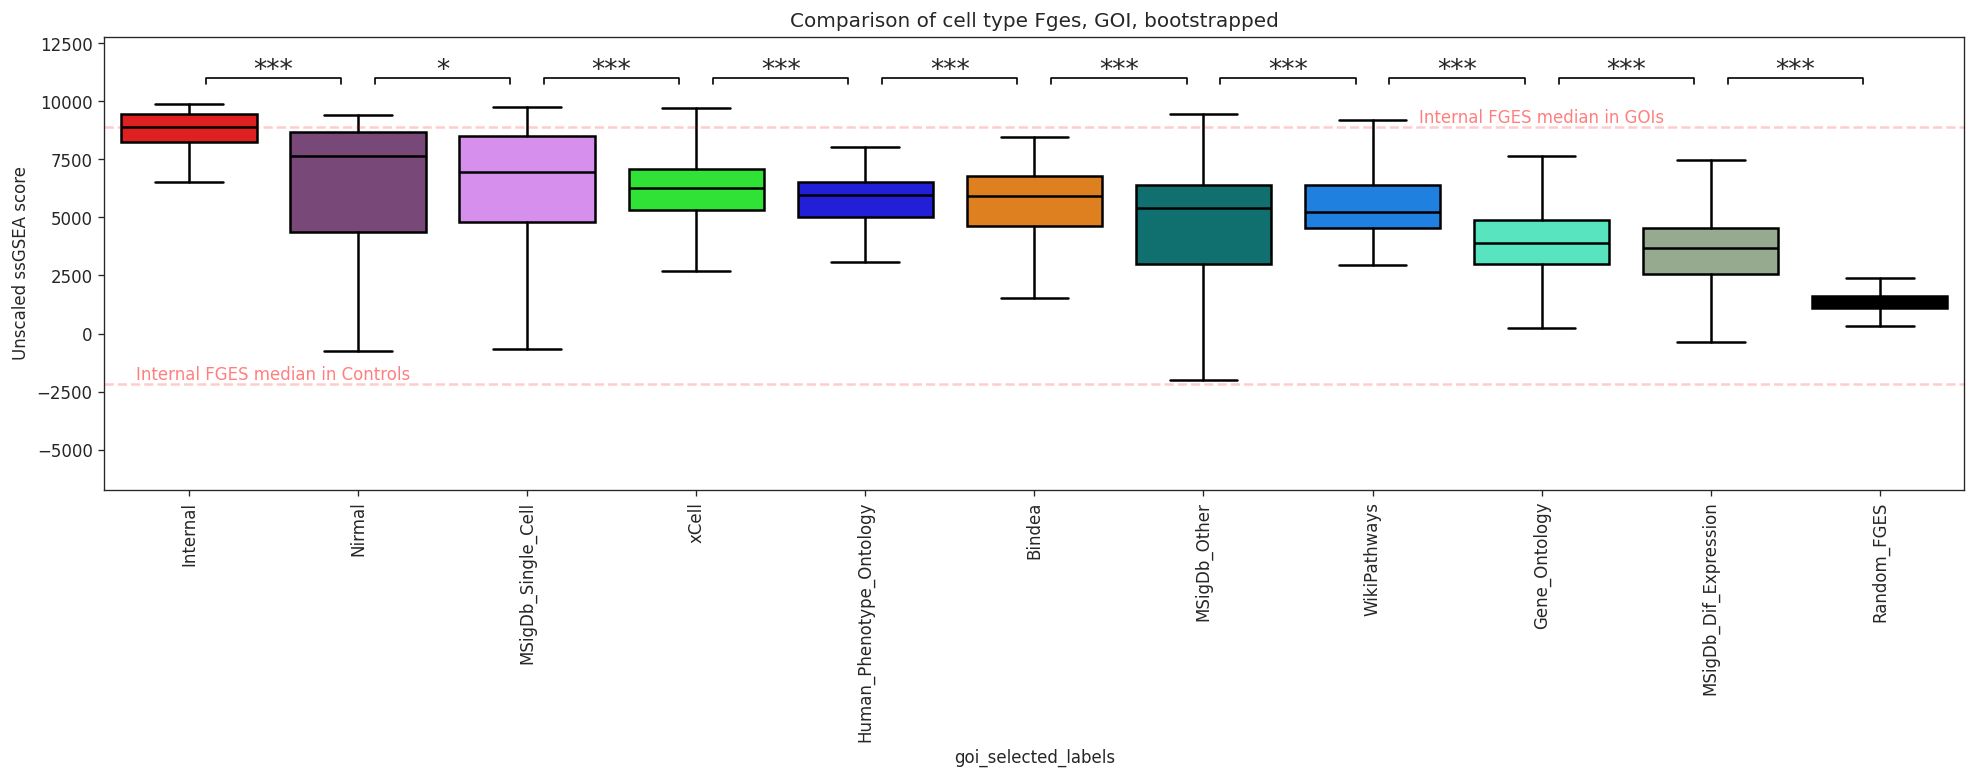

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
o = signture_order
num = out_goi.goi_ss.dropna()
labels = out_goi.goi_selected_labels.dropna()

boxplot_with_pvalue(
    num,
    labels,
    palette=signature_palette,
    ax=ax,
    title="Comparison of cell type Fges, GOI, bootstrapped",
    violin=False,
    swarm=False,
    s=1,
    order=o,
)
ax.set_xticklabels(o, rotation=90)

num = out_goi.goi_ss.dropna()
labels = out_goi.goi_selected_labels.dropna()

y_pos = num[labels.isin(["Internal"])].median()
ax.axhline(y=y_pos, color="r", linestyle="--", alpha=0.2)
x_pos = 8
ax.text(
    x_pos,
    y_pos,
    "Internal FGES median in GOIs",
    color="r",
    va="bottom",
    ha="center",
    alpha=0.5,
)

num = out_control.control_ss.dropna()
labels = out_control.control_selected_labels.dropna()

y_pos = num[labels.isin(["Internal"])].median()
ax.axhline(y=y_pos, color="r", linestyle="--", alpha=0.2)
x_pos = 0.5
ax.text(
    x_pos,
    y_pos,
    "Internal FGES median in Controls",
    color="r",
    va="bottom",
    ha="center",
    alpha=0.5,
)

plt.ylabel("Unscaled ssGSEA score")
plt.rcParams["svg.fonttype"] = "none"
plt.savefig(f"boxplot_comparison_nonscaled_GOI_no_swarm.svg", format="svg")

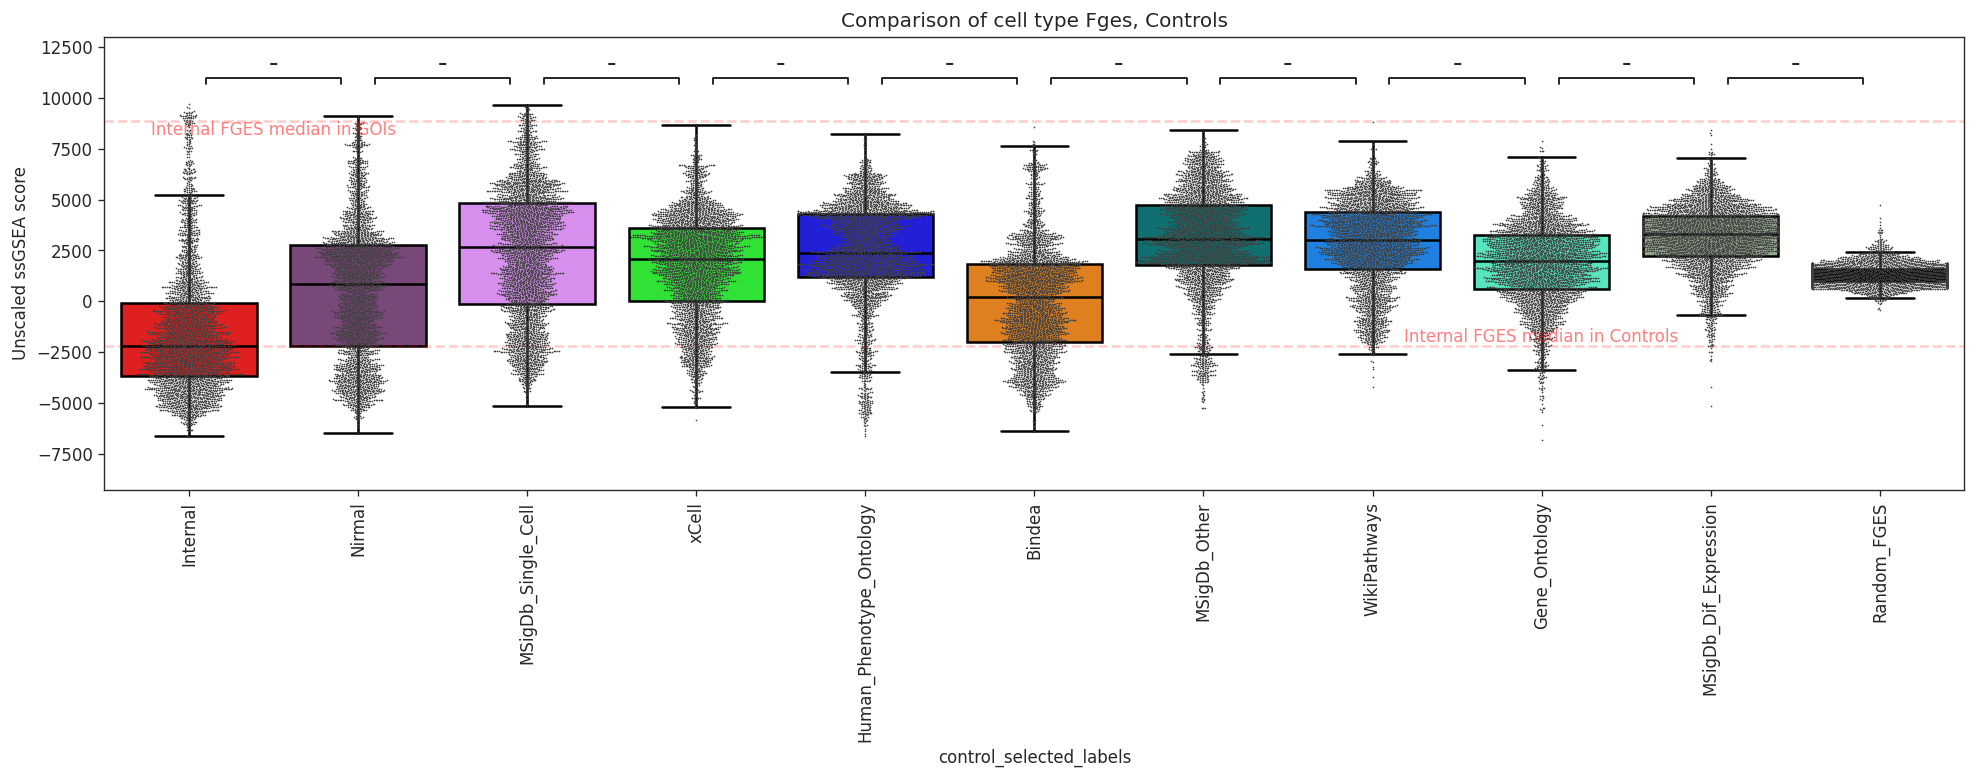

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
o = signture_order
num = out_control.control_ss.dropna()
labels = out_control.control_selected_labels.dropna()

boxplot_with_pvalue(
    num,
    labels,
    palette=signature_palette,
    ax=ax,
    title="Comparison of cell type Fges, Controls",
    violin=False,
    swarm=True,
    s=1,
    order=o,
)
ax.set_xticklabels(o, rotation=90)

num = out_goi.goi_ss.dropna()
labels = out_goi.goi_selected_labels.dropna()

y_pos = num[labels.isin(["Internal"])].median()
ax.axhline(y=y_pos, color="r", linestyle="--", alpha=0.2)
x_pos = 0.5
ax.text(
    x_pos,
    y_pos,
    "Internal FGES median in GOIs",
    color="r",
    va="top",
    ha="center",
    alpha=0.5,
)

num = out_control.control_ss.dropna()
labels = out_control.control_selected_labels.dropna()

y_pos = num[labels.isin(["Internal"])].median()
ax.axhline(y=y_pos, color="r", linestyle="--", alpha=0.2)
x_pos = 8
ax.text(
    x_pos,
    y_pos,
    "Internal FGES median in Controls",
    color="r",
    va="bottom",
    ha="center",
    alpha=0.5,
)

plt.ylabel("Unscaled ssGSEA score")
plt.rcParams["svg.fonttype"] = "none"
plt.savefig(f"boxplot_comparison_nonscaled_controls.svg", format="svg")

In [ ]:
samps = pd.Series(
    index=out_control.index,
    data=out_control.index.map(lambda x: x.split("', '")[1].split("')_")[0]),
)

In [ ]:
for name, group in samps[samps == "SRX9506021"].groupby(
    out_control.control_selected_labels
):
    print(name)
    print(group)

Bindea
('Monocytic_DC', 'SRX9506021')_Bindea_BINDEA_ET_AL_MACROPHAGES    SRX9506021
dtype: object
Gene_Ontology
('Monocytic_DC', 'SRX9506021')_Gene_Ontology_GOBP_T_CELL_ACTIVATION    SRX9506021
dtype: object
Human_Phenotype_Ontology
('Monocytic_DC', 'SRX9506021')_Human_Phenotype_Ontology_HP_ABNORMAL_B_CELL_MORPHOLOGY    SRX9506021
dtype: object
Internal
('Monocytic_DC', 'SRX9506021')_Internal_Main4_Mast_cell_signature    SRX9506021
dtype: object
MSigDb_Dif_Expression
('Monocytic_DC', 'SRX9506021')_MSigDb_Dif_Expression_GSE45365_NK_CELL_VS_BCELL_MCMV_INFECTION_DN    SRX9506021
dtype: object
MSigDb_Other
('Monocytic_DC', 'SRX9506021')_MSigDb_Other_LEE_NAIVE_T_LYMPHOCYTE    SRX9506021
dtype: object
MSigDb_Single_Cell
('Monocytic_DC', 'SRX9506021')_MSigDb_Single_Cell_TRAVAGLINI_LUNG_PROLIFERATING_MACROPHAGE_CELL    SRX9506021
dtype: object
Nirmal
('Monocytic_DC', 'SRX9506021')_Nirmal_T_CELLS_NIRMAL    SRX9506021
dtype: object
Random_FGES
('Monocytic_DC', 'SRX9506021')_Random_FGES_RANDOM_FG

In [ ]:
x = pd.crosstab(out_control.control_selected_labels, samps)
ind = []
for s in samps.unique():
    print(s)
    s_part = samps[samps == s]
    min_num = x[s].min()
    for name, group in s_part.groupby(out_control.control_selected_labels):
        ind += group.sample(min_num).index.to_list()
        print(name, len(group.sample(min_num).index.to_list()))

SRX9506021
Bindea 1
Gene_Ontology 1
Human_Phenotype_Ontology 1
Internal 1
MSigDb_Dif_Expression 1
MSigDb_Other 1
MSigDb_Single_Cell 1
Nirmal 1
Random_FGES 1
WikiPathways 1
xCell 1
SRX5305750
Bindea 1
Gene_Ontology 1
Human_Phenotype_Ontology 1
Internal 1
MSigDb_Dif_Expression 1
MSigDb_Other 1
MSigDb_Single_Cell 1
Nirmal 1
Random_FGES 1
WikiPathways 1
xCell 1
SRX8932153
Bindea 1
Gene_Ontology 1
Human_Phenotype_Ontology 1
Internal 1
MSigDb_Dif_Expression 1
MSigDb_Other 1
MSigDb_Single_Cell 1
Nirmal 1
Random_FGES 1
WikiPathways 1
xCell 1
SRX4737313
Bindea 3
Gene_Ontology 3
Human_Phenotype_Ontology 3
Internal 3
MSigDb_Dif_Expression 3
MSigDb_Other 3
MSigDb_Single_Cell 3
Nirmal 3
Random_FGES 3
WikiPathways 3
xCell 3
SRX611345
Bindea 1
Gene_Ontology 1
Human_Phenotype_Ontology 1
Internal 1
MSigDb_Dif_Expression 1
MSigDb_Other 1
MSigDb_Single_Cell 1
Nirmal 1
Random_FGES 1
WikiPathways 1
xCell 1
SRX4804508
Bindea 1
Gene_Ontology 1
Human_Phenotype_Ontology 1
Internal 1
MSigDb_Dif_Expression 1
MSi

In [ ]:
out_control.loc[ind].to_csv("out_control_lock.tsv.gz", sep="\t", compression="gzip")

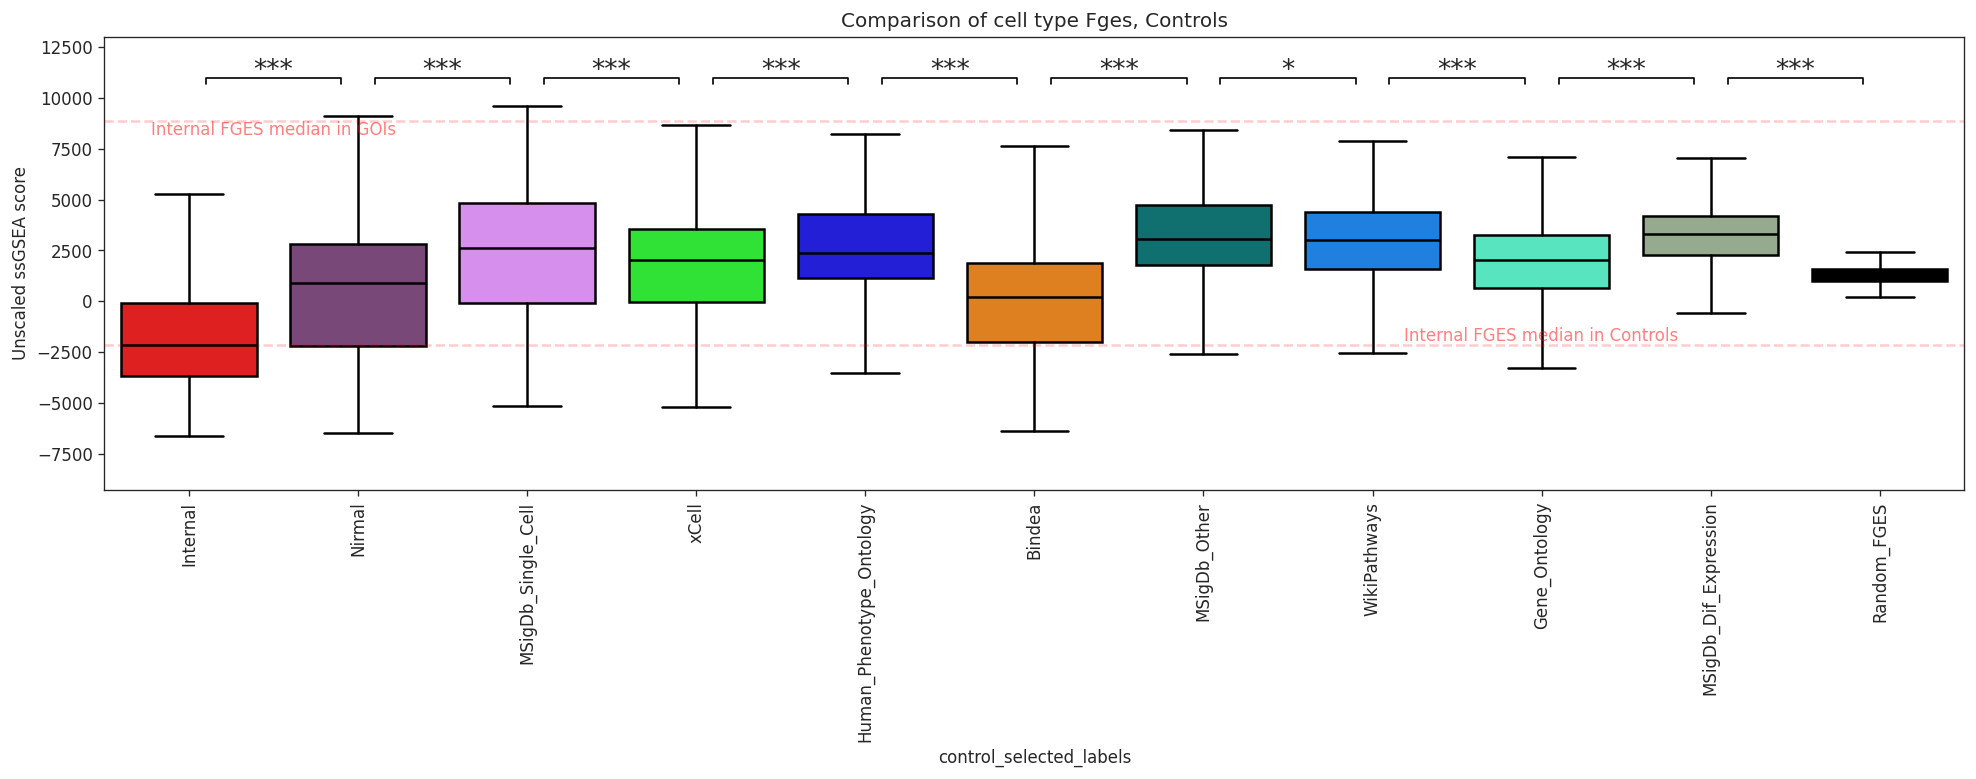

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
o = signture_order
num = out_control.loc[ind].control_ss.dropna()
labels = out_control.loc[ind].control_selected_labels.dropna()

boxplot_with_pvalue(
    num,
    labels,
    palette=signature_palette,
    ax=ax,
    title="Comparison of cell type Fges, Controls",
    violin=False,
    swarm=False,
    s=1,
    order=o,
)
ax.set_xticklabels(o, rotation=90)

num = out_goi.goi_ss.dropna()
labels = out_goi.goi_selected_labels.dropna()

y_pos = num[labels.isin(["Internal"])].median()
ax.axhline(y=y_pos, color="r", linestyle="--", alpha=0.2)
x_pos = 0.5
ax.text(
    x_pos,
    y_pos,
    "Internal FGES median in GOIs",
    color="r",
    va="top",
    ha="center",
    alpha=0.5,
)

num = out_control.loc[ind].control_ss.dropna()
labels = out_control.loc[ind].control_selected_labels.dropna()

y_pos = num[labels.isin(["Internal"])].median()
ax.axhline(y=y_pos, color="r", linestyle="--", alpha=0.2)
x_pos = 8
ax.text(
    x_pos,
    y_pos,
    "Internal FGES median in Controls",
    color="r",
    va="bottom",
    ha="center",
    alpha=0.5,
)

plt.ylabel("Unscaled ssGSEA score")
plt.rcParams["svg.fonttype"] = "none"
plt.savefig(f"boxplot_comparison_nonscaled_controls_no_swarm.svg", format="svg")

# Violins

In [ ]:
out = read_dataset("box_plot_selected_data.tsv.gz")

Selecting runs...:   0%|          | 3372/16563294 [1:14:55<6132:13:32,  1.33s/it]


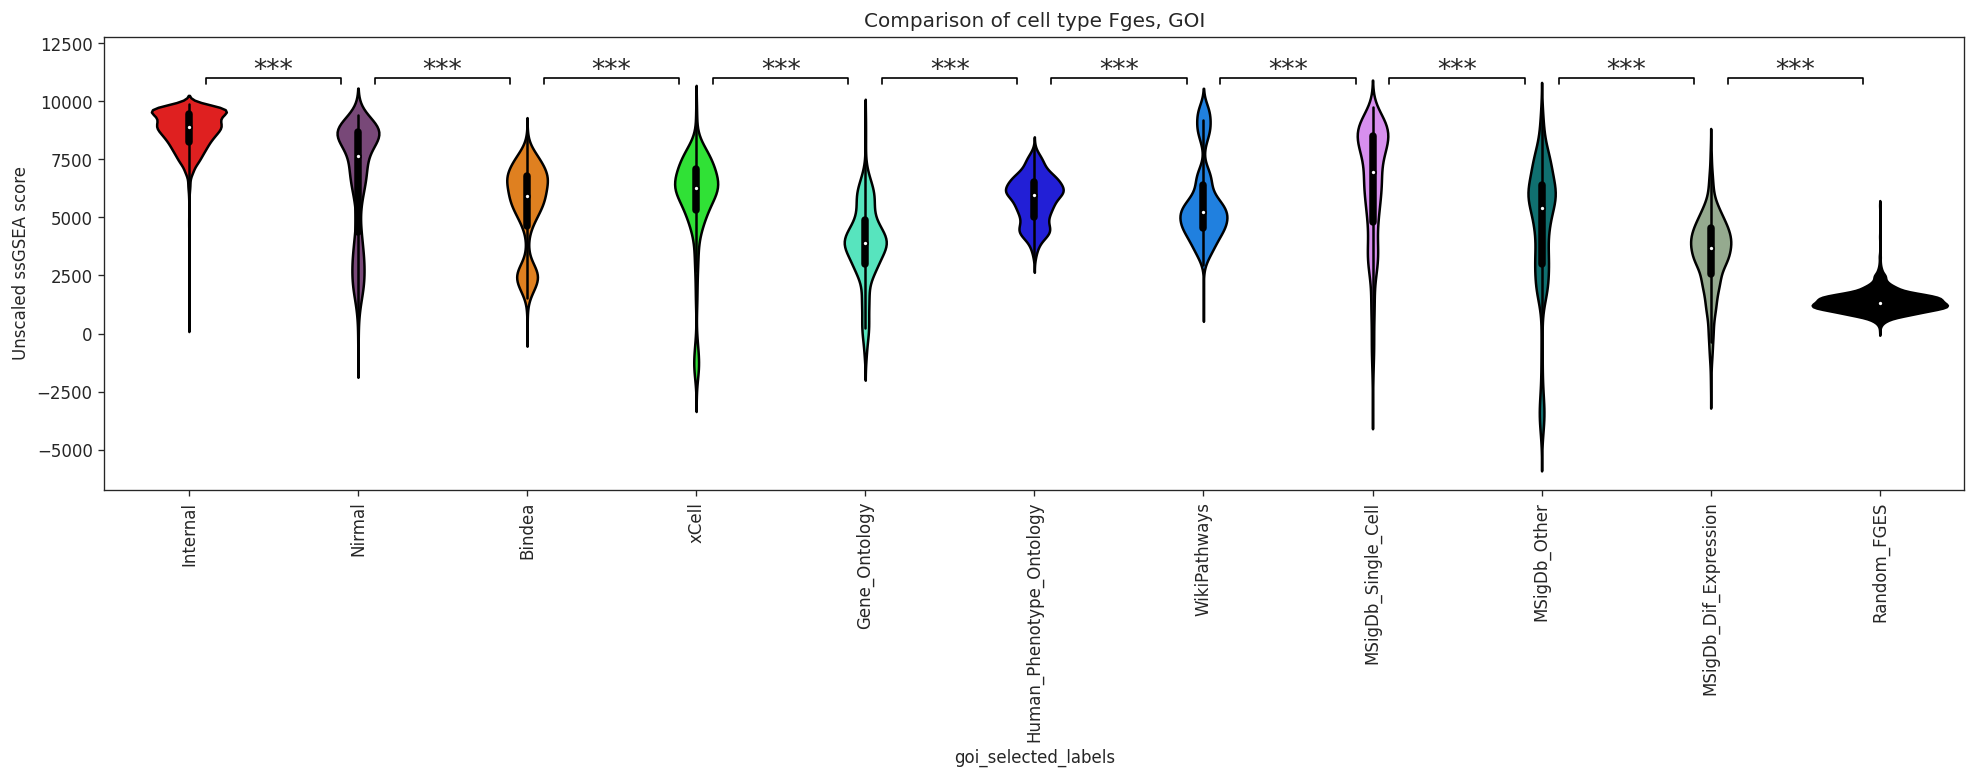

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
o = signture_order

num = out.goi_ss.dropna()
labels = out.goi_selected_labels.dropna()

boxplot_with_pvalue(
    num,
    labels,
    palette=signature_palette,
    ax=ax,
    title="Comparison of cell type Fges, GOI",
    violin=True,
    order=o,
)
ax.set_xticklabels(o, rotation=90)

num = out.goi_ss.dropna()
labels = out.goi_selected_labels.dropna()

y_pos = num[labels.isin(["BostonGene"])].median()
ax.axhline(y=y_pos, color="r", linestyle="--", alpha=0.2)
x_pos = 8
ax.text(
    x_pos,
    y_pos,
    "BG FGES median in GOIs",
    color="r",
    va="center",
    ha="center",
    alpha=0.5,
)

num = out.control_ss.dropna()
labels = out.control_selected_labels.dropna()

y_pos = num[labels.isin(["BostonGene"])].median()
ax.axhline(y=y_pos, color="r", linestyle="--", alpha=0.2)
x_pos = 0.5
ax.text(
    x_pos,
    y_pos,
    "BG FGES median in Controls",
    color="r",
    va="center",
    ha="center",
    alpha=0.5,
)

plt.ylabel("Unscaled ssGSEA score")
plt.rcParams["svg.fonttype"] = "none"
plt.savefig(f"violin_comparison_nonscaled_GOI.svg", format="svg")

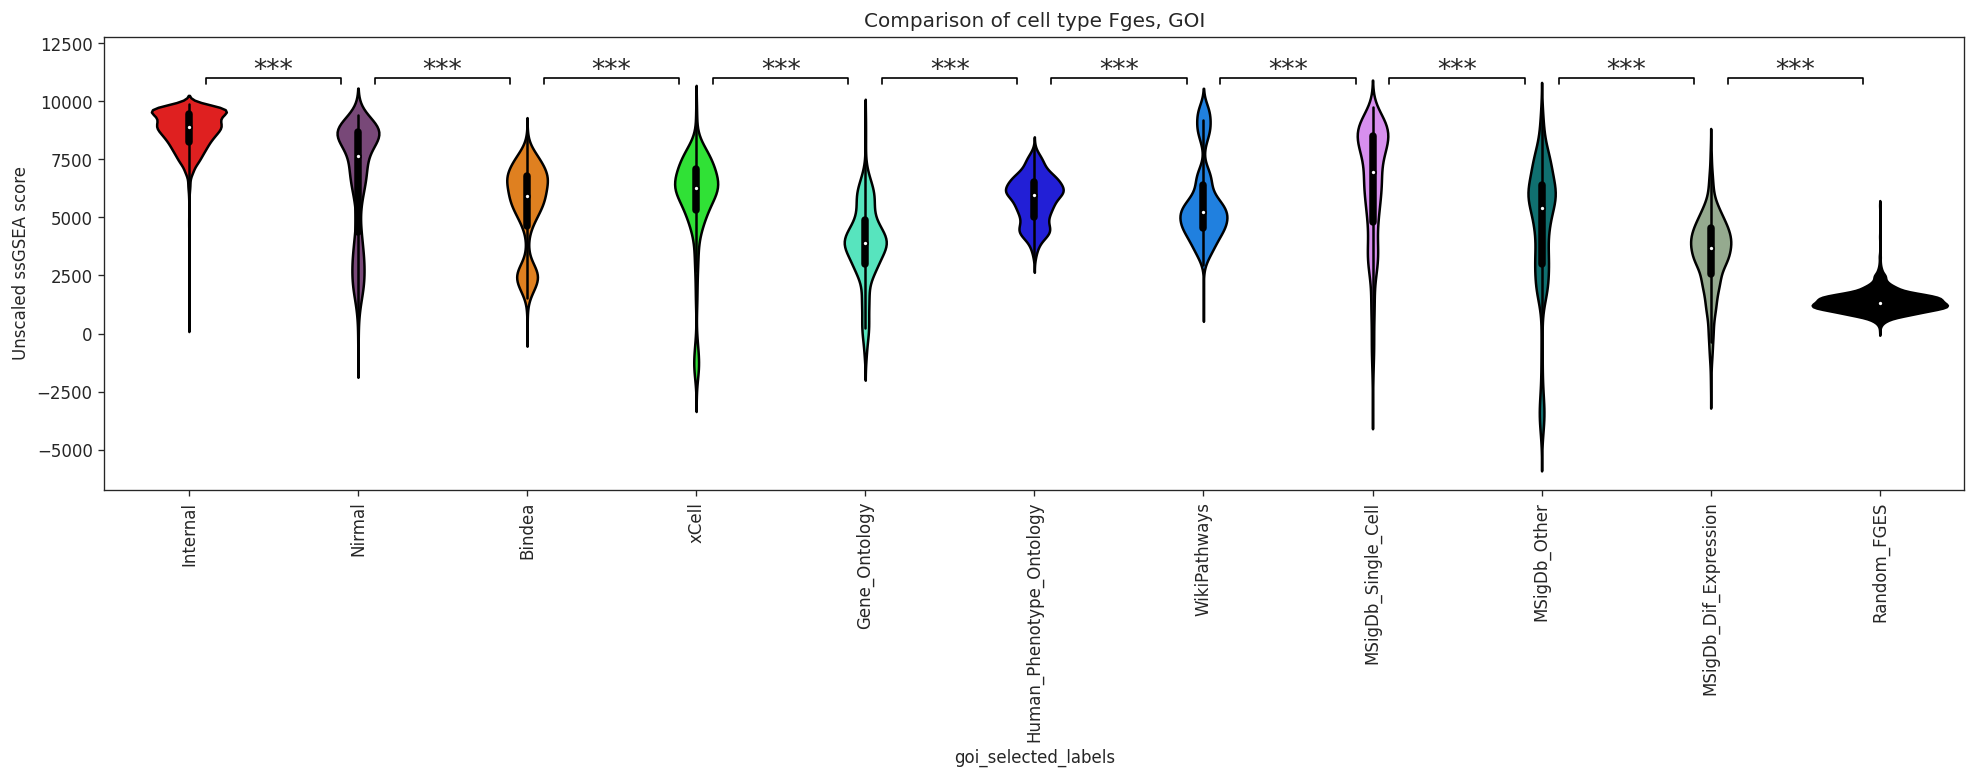

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
o = signture_order

num = out.goi_ss.dropna()
labels = out.goi_selected_labels.dropna()

boxplot_with_pvalue(
    num,
    labels,
    palette=signature_palette,
    ax=ax,
    title="Comparison of cell type Fges, GOI",
    violin=True,
    order=o,
)
ax.set_xticklabels(o, rotation=90)

num = out.goi_ss.dropna()
labels = out.goi_selected_labels.dropna()
num, labels = to_common_samples((num, labels))

y_pos = num[labels.isin(["BostonGene"])].median()
ax.axhline(y=y_pos, color="r", linestyle="--", alpha=0.2)
x_pos = 8
ax.text(
    x_pos,
    y_pos,
    "BG FGES median in GOIs",
    color="r",
    va="bottom",
    ha="center",
    alpha=0.5,
)

num = control_ss
labels = control_labels_good
num, labels = to_common_samples((num, labels))

y_pos = num[labels.isin(["BostonGene"])].median()
ax.axhline(y=y_pos, color="r", linestyle="--", alpha=0.2)
x_pos = 0.5
ax.text(
    x_pos,
    y_pos,
    "BG FGES median in Controls",
    color="r",
    va="bottom",
    ha="center",
    alpha=0.5,
)

plt.ylabel("Unscaled ssGSEA score")
plt.rcParams["svg.fonttype"] = "none"
# plt.savefig(f"violin_comparison_nonscaled_GOI.svg", format="svg")

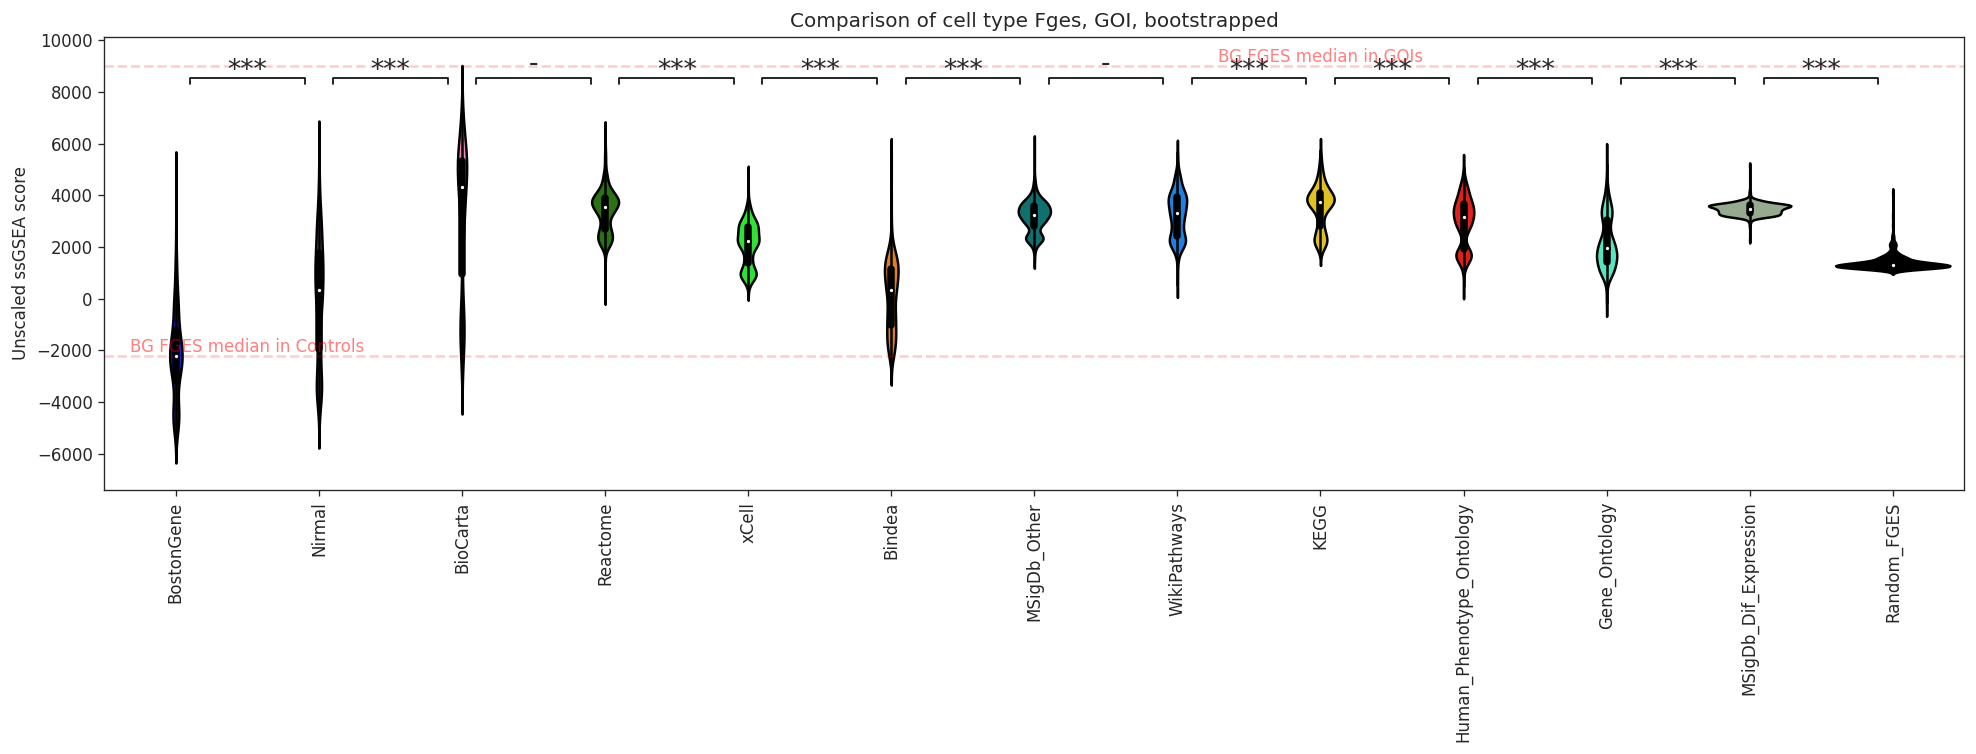

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
o = [
    "BostonGene",
    "Nirmal",
    "BioCarta",
    "Reactome",
    "xCell",
    "Bindea",
    "MSigDb_Other",
    "WikiPathways",
    "KEGG",
    "Human_Phenotype_Ontology",
    "Gene_Ontology",
    "MSigDb_Dif_Expression",
    "Random_FGES",
]

num = control_ss_bootstrapped
labels = control_ls_bootstrapped

boxplot_with_pvalue(
    num,
    labels,
    palette=signature_palette,
    ax=ax,
    title="Comparison of cell type Fges, GOI, bootstrapped",
    violin=True,
    order=o,
)
ax.set_xticklabels(o, rotation=90)

num = goi_ss_bootstrapped
labels = goi_ls_bootstrapped

y_pos = num[labels.isin(["BostonGene"])].median()
ax.axhline(y=y_pos, color="r", linestyle="--", alpha=0.2)
x_pos = 8
ax.text(
    x_pos,
    y_pos,
    "BG FGES median in GOIs",
    color="r",
    va="bottom",
    ha="center",
    alpha=0.5,
)

num = control_ss_bootstrapped
labels = control_ls_bootstrapped

y_pos = num[labels.isin(["BostonGene"])].median()
ax.axhline(y=y_pos, color="r", linestyle="--", alpha=0.2)
x_pos = 0.5
ax.text(
    x_pos,
    y_pos,
    "BG FGES median in Controls",
    color="r",
    va="bottom",
    ha="center",
    alpha=0.5,
)

plt.ylabel("Unscaled ssGSEA score")
plt.rcParams["svg.fonttype"] = "none"
# plt.savefig(f"violin_comparison_nonscaled_GOI.svg", format="svg")

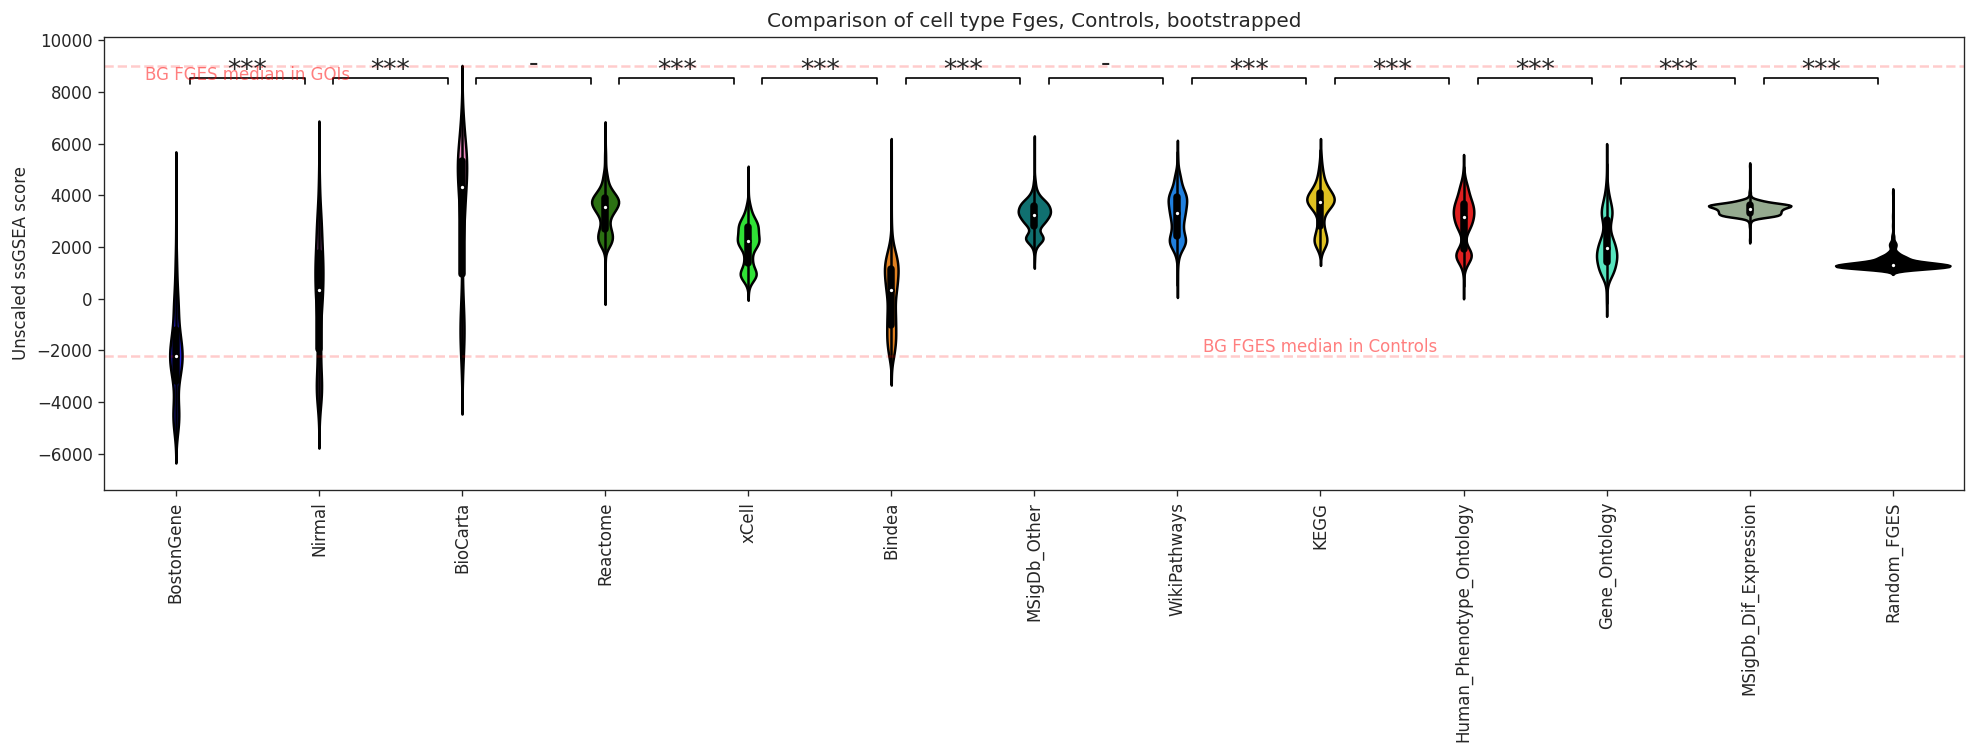

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
o = [
    "BostonGene",
    "Nirmal",
    "BioCarta",
    "Reactome",
    "xCell",
    "Bindea",
    "MSigDb_Other",
    "WikiPathways",
    "KEGG",
    "Human_Phenotype_Ontology",
    "Gene_Ontology",
    "MSigDb_Dif_Expression",
    "Random_FGES",
]

num = control_ss_bootstrapped
labels = control_ls_bootstrapped

boxplot_with_pvalue(
    num,
    labels,
    palette=signature_palette,
    ax=ax,
    title="Comparison of cell type Fges, Controls, bootstrapped",
    violin=True,
    order=o,
)
ax.set_xticklabels(o, rotation=90)

num = goi_ss_bootstrapped
labels = goi_ls_bootstrapped

y_pos = num[labels.isin(["BostonGene"])].median()
ax.axhline(y=y_pos, color="r", linestyle="--", alpha=0.2)
x_pos = 0.5
ax.text(
    x_pos, y_pos, "BG FGES median in GOIs", color="r", va="top", ha="center", alpha=0.5
)

num = control_ss_bootstrapped
labels = control_ls_bootstrapped

y_pos = num[labels.isin(["BostonGene"])].median()
ax.axhline(y=y_pos, color="r", linestyle="--", alpha=0.2)
x_pos = 8
ax.text(
    x_pos,
    y_pos,
    "BG FGES median in Controls",
    color="r",
    va="bottom",
    ha="center",
    alpha=0.5,
)

plt.ylabel("Unscaled ssGSEA score")
plt.rcParams["svg.fonttype"] = "none"
# plt.savefig(f"violin_comparison_nonscaled_GOI.svg", format="svg")

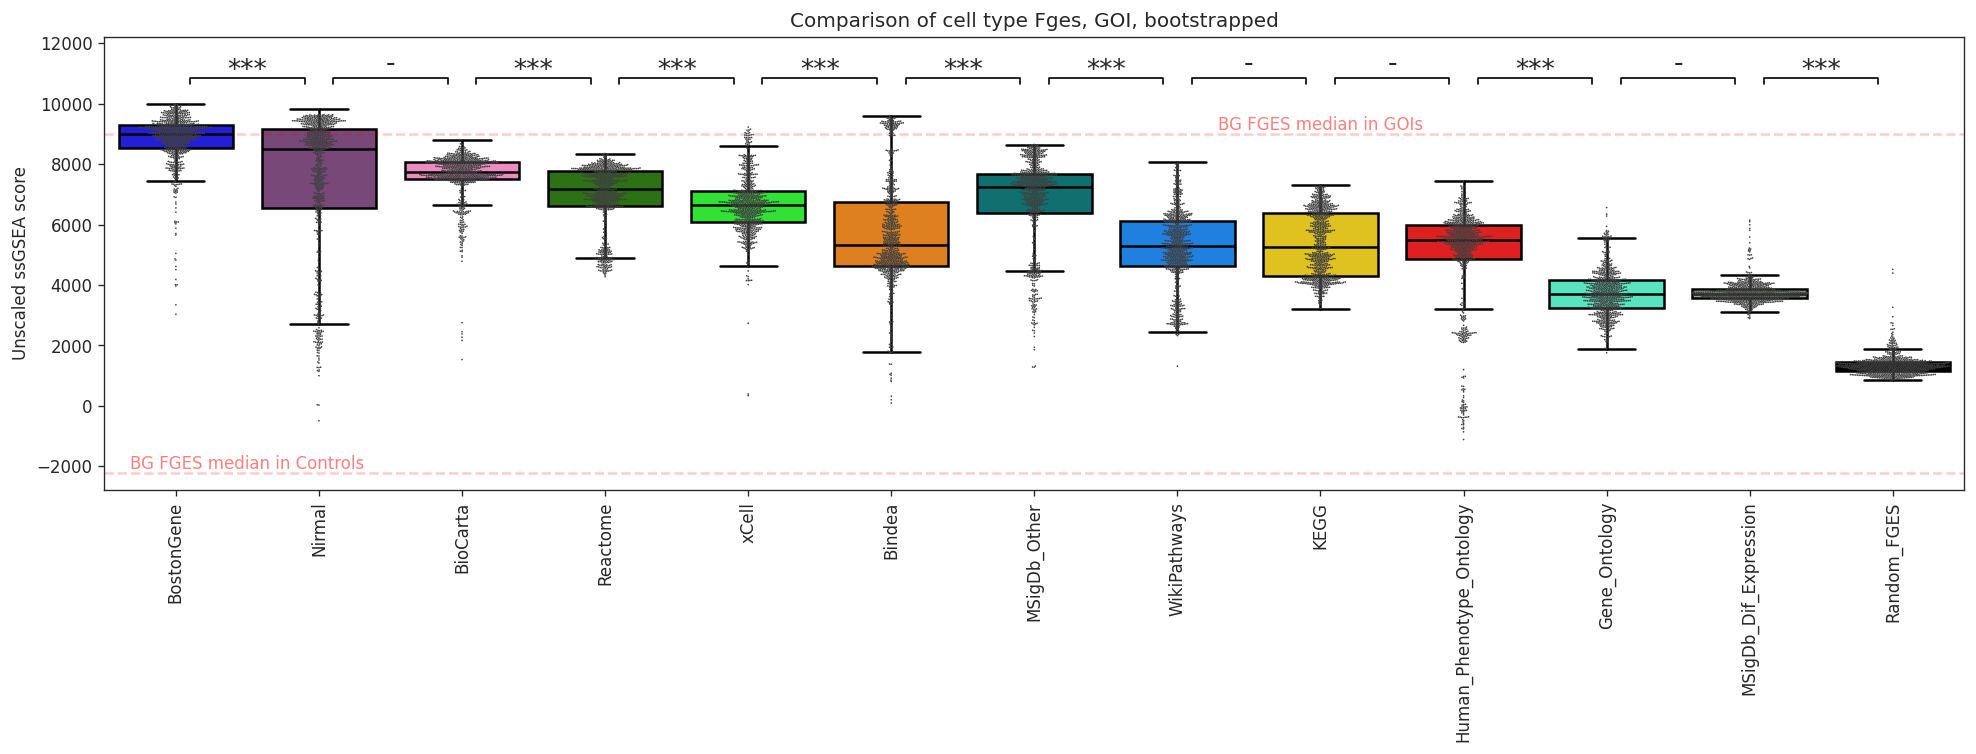

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
o = [
    "BostonGene",
    "Nirmal",
    "BioCarta",
    "Reactome",
    "xCell",
    "Bindea",
    "MSigDb_Other",
    "WikiPathways",
    "KEGG",
    "Human_Phenotype_Ontology",
    "Gene_Ontology",
    "MSigDb_Dif_Expression",
    "Random_FGES",
]

num = goi_ss_bootstrapped
labels = goi_ls_bootstrapped

boxplot_with_pvalue(
    num,
    labels,
    palette=signature_palette,
    ax=ax,
    title="Comparison of cell type Fges, GOI, bootstrapped",
    violin=False,
    swarm=True,
    s=1,
    order=o,
)
ax.set_xticklabels(o, rotation=90)

num = goi_ss_bootstrapped
labels = goi_ls_bootstrapped

y_pos = num[labels.isin(["BostonGene"])].median()
ax.axhline(y=y_pos, color="r", linestyle="--", alpha=0.2)
x_pos = 8
ax.text(
    x_pos,
    y_pos,
    "BG FGES median in GOIs",
    color="r",
    va="bottom",
    ha="center",
    alpha=0.5,
)

num = control_ss_bootstrapped
labels = control_ls_bootstrapped

y_pos = num[labels.isin(["BostonGene"])].median()
ax.axhline(y=y_pos, color="r", linestyle="--", alpha=0.2)
x_pos = 0.5
ax.text(
    x_pos,
    y_pos,
    "BG FGES median in Controls",
    color="r",
    va="bottom",
    ha="center",
    alpha=0.5,
)

plt.ylabel("Unscaled ssGSEA score")
plt.rcParams["svg.fonttype"] = "none"
plt.savefig(f"boxplot_comparison_nonscaled_GOI.svg", format="svg")

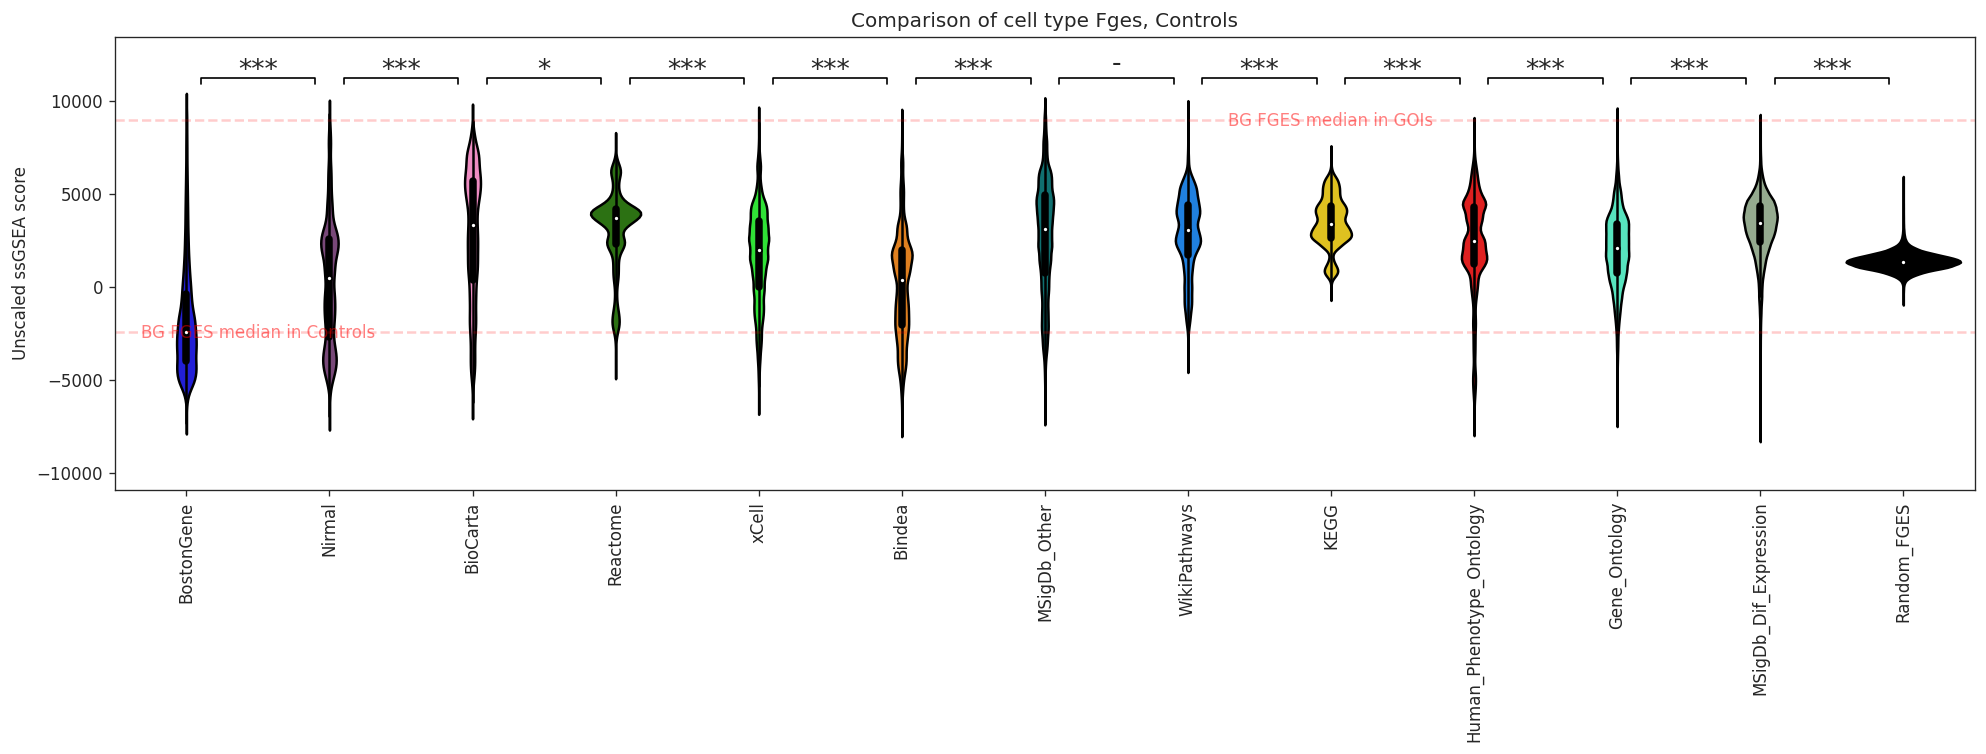

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
o = [
    "BostonGene",
    "Nirmal",
    "BioCarta",
    "Reactome",
    "xCell",
    "Bindea",
    "MSigDb_Other",
    "WikiPathways",
    "KEGG",
    "Human_Phenotype_Ontology",
    "Gene_Ontology",
    "MSigDb_Dif_Expression",
    "Random_FGES",
]

boxplot_with_pvalue(
    control_ss,
    control_labels,
    palette=signature_palette,
    ax=ax,
    title="Comparison of cell type Fges, Controls",
    violin=True,
    order=o,
)
ax.set_xticklabels(o, rotation=90)

y_pos = goi_ss[goi_labels.isin(["BostonGene"])].median()
ax.axhline(y=y_pos, color="r", linestyle="--", alpha=0.2)
x_pos = 8
ax.text(
    x_pos,
    y_pos,
    "BG FGES median in GOIs",
    color="r",
    va="center",
    ha="center",
    alpha=0.5,
)

y_pos = control_ss[control_labels.isin(["BostonGene"])].median()
ax.axhline(y=y_pos, color="r", linestyle="--", alpha=0.2)
x_pos = 0.5
ax.text(
    x_pos,
    y_pos,
    "BG FGES median in Controls",
    color="r",
    va="center",
    ha="center",
    alpha=0.5,
)

plt.ylabel("Unscaled ssGSEA score")
plt.rcParams["svg.fonttype"] = "none"
plt.savefig(f"violin_comparison_nonscaled_controls.svg", format="svg")

In [ ]:
ss = {}
ls = {}
for start in range(len(o)):
    name = o[start]
    x = control_ss[control_labels == o[start]].dropna()
    x.index = x.index.map(lambda x: x.split(", ")[-1].split(")_")[0].replace("'", ""))
    xmed = x.median()
    x = x.groupby(x.index).median().sample(776)
    if start != len(o) - 1:
        fin = start + 1
        y = control_ss[control_labels == o[fin]].dropna()
        ymed = y.median()
        y.index = y.index.map(
            lambda x: x.split(", ")[-1].split(")_")[0].replace("'", "")
        )
        y = y.groupby(y.index).median().sample(776)
        _, p = wilcoxon(x, y)
        print(f"{o[start]}\t{o[fin]}\t{p}\t{xmed}\t{ymed}")
    x.index = x.index.map(lambda i: f"{i}_{name}")
    ss[name] = x
    ls[name] = pd.Series(index=x.index, data=[name for i in x.index])
ss = pd.concat(ss.values())
ls = pd.concat(ls.values())